The last notebook I wrote doesn't seem to be working at finding the missed stars. I'm going to take the plunge and just do the easy thing. I'm going to call PSFEx on each individual exposure at a time, and have it write a custom outcat file. Then I'll have them all on a CCD by CCD basis easily. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits
from collections import defaultdict
from glob import glob
from subprocess import call

expid = 149440
data_dir = '/u/ki/swmclau2/des/DeconvOutput/00%d/'%expid

bad_star_idxs = np.load(data_dir+'%d_bad_star_idxs.npy'%expid)
print bad_star_idxs

[    1     6     7 ..., 28799 28801 28805]


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import DeconvolvePSF.colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
plt.set_cmap(cmaps.viridis)

In [3]:
fits_files = sorted(glob(data_dir+'*_seldeconv.fits'))

meta_hdulist = [fits.open(f) for f in fits_files]
hdu_lengths = np.zeros((62,))

for ccd_num, hdulist in enumerate(meta_hdulist):
    hdu_lengths[ccd_num] = hdulist[2].data.shape[0]
    
ccd_jumps = np.cumsum(hdu_lengths)

#TODO horribly named! fix!
ccd_dict = defaultdict(list)
for idx, bs in enumerate(bad_star_idxs):
    for ccd, hdul in enumerate(hdu_lengths):
        if bs > hdul:
            bs-=hdul
        else:
            ccd_dict[ccd+1].append(int(bs+1) )
            break

In [4]:
#call psfex
from os.path import exists
psfex_path = '/nfs/slac/g/ki/ki22/roodman/EUPS_DESDM/eups/packages/Linux64/psfex/3.17.3+0/bin/psfex'
psfex_config = '/afs/slac.stanford.edu/u/ec/roodman/Astrophysics/PSF/desdm-plus.psfex'

psfex_used_stars = {}
for ccd, fname in enumerate(fits_files):
    outcat_name = data_dir+ '%d_%d_outcat.cat'%(expid, ccd)
    
    if not exists(outcat_name):
        command_list = [psfex_path, fname, "-c", psfex_config, "-OUTCAT_NAME",outcat_name ]

        #If shell != True, the wildcard won't work
        psfex_return= call(' '.join(command_list), shell = True)
        psfex_success = True if psfex_return==0 else False
        print 'PSFEx Call %d Successful: %s'%(ccd, psfex_success)
    
    out_cat = fits.open(outcat_name)
    psfex_used_stars[ccd+1] = set(out_cat[2].data['SOURCE_NUMBER'])

In [5]:
for key, value in psfex_used_stars.iteritems():
    print len(value)

438
430
425
422
474
433
461
456
446
485
464
441
455
460
429
502
464
480
413
448
433
477
455
413
426
410
486
435
502
474
478
454
514
485
469
500
507
440
391
462
493
494
493
514
465
456
438
491
462
506
472
491
497
499
482
475
481
455
527
458
480


In [6]:
for ccd in xrange(1,61):
    psfex = psfex_used_stars[ccd]
    bad_stars = ccd_dict[ccd]
    for bs in bad_stars:
        if bs in psfex:
            print "%d is a bad star in psfex for ccd %d"%(bs, ccd)

2 is a bad star in psfex for ccd 1
7 is a bad star in psfex for ccd 1
8 is a bad star in psfex for ccd 1
9 is a bad star in psfex for ccd 1
16 is a bad star in psfex for ccd 1
26 is a bad star in psfex for ccd 1
30 is a bad star in psfex for ccd 1
65 is a bad star in psfex for ccd 1
68 is a bad star in psfex for ccd 1
71 is a bad star in psfex for ccd 1
77 is a bad star in psfex for ccd 1
80 is a bad star in psfex for ccd 1
83 is a bad star in psfex for ccd 1
85 is a bad star in psfex for ccd 1
92 is a bad star in psfex for ccd 1
93 is a bad star in psfex for ccd 1
94 is a bad star in psfex for ccd 1
97 is a bad star in psfex for ccd 1
100 is a bad star in psfex for ccd 1
102 is a bad star in psfex for ccd 1
106 is a bad star in psfex for ccd 1
114 is a bad star in psfex for ccd 1
120 is a bad star in psfex for ccd 1
121 is a bad star in psfex for ccd 1
123 is a bad star in psfex for ccd 1
125 is a bad star in psfex for ccd 1
130 is a bad star in psfex for ccd 1
131 is a bad star in ps

In [7]:
psfex_bad_stars = defaultdict(set)
for ccd in xrange(1,61):
    psfex_used = psfex_used_stars[ccd]
    hdl = hdu_lengths[ccd]
    for idx in xrange(1, int(hdl)+1):
        if idx not in psfex_used:
            psfex_bad_stars[ccd].add(idx)

In [16]:
t1 = 0
t2 = 0
for ccd in xrange(1,61):
    #print len(psfex_bad_stars[ccd]), len(ccd_dict[ccd]), len(psfex_bad_stars[ccd]-set(ccd_dict[ccd]) )
    t1+=len(psfex_bad_stars[ccd]-set(ccd_dict[ccd]) )
    t2+=len(set(ccd_dict[ccd]) - psfex_bad_stars[ccd] )

print 'PSFEx Bad Stars not ours, and Ours not caught'
print t1, t2

PSFEx Bad Stars not ours, and Ours not caught
1153 5111


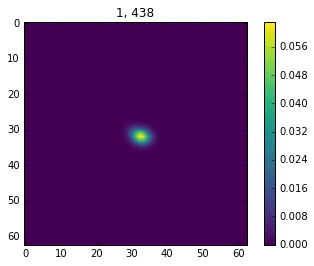

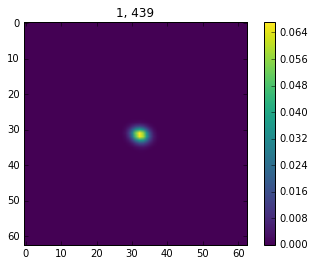

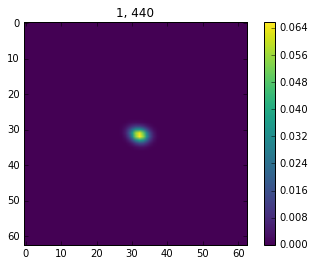

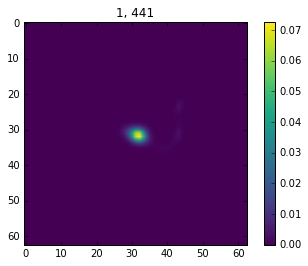

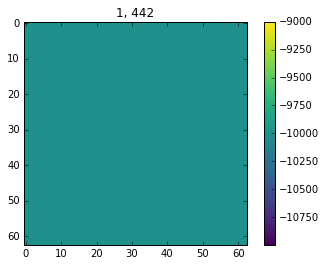

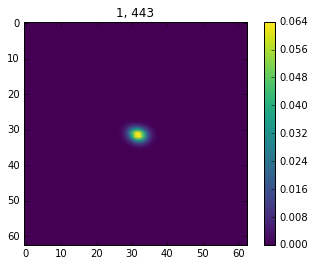

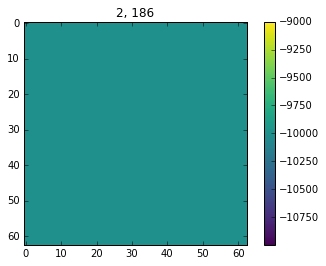

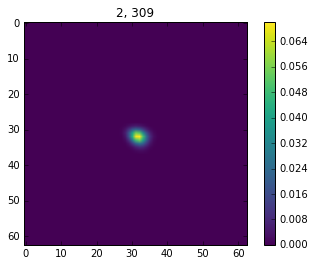

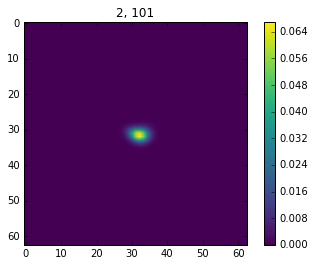

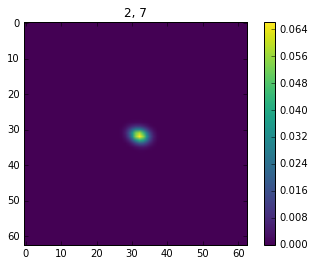

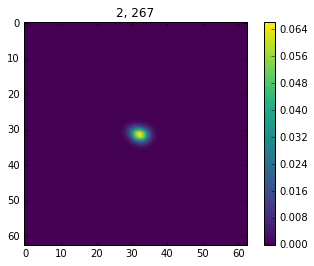

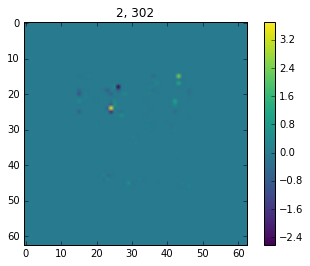

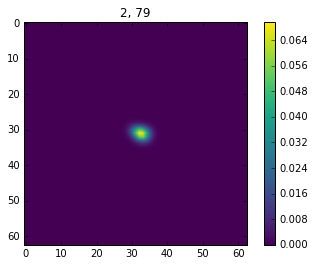

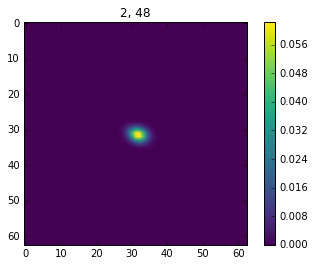

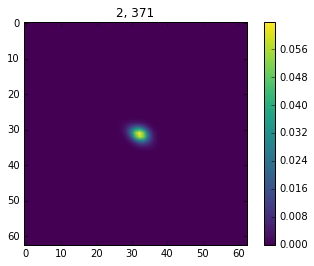

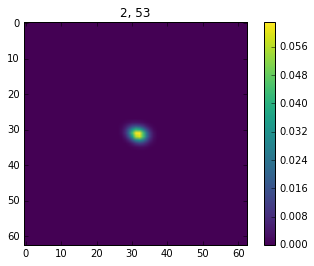

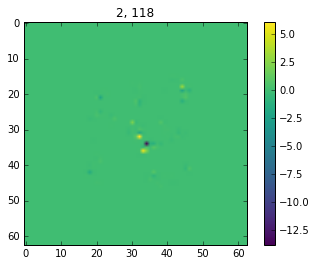

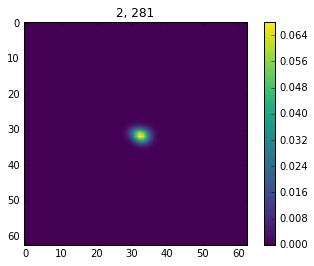

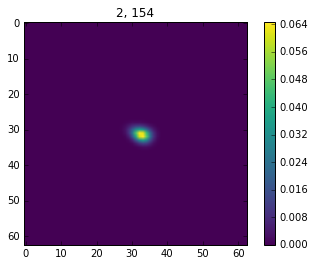

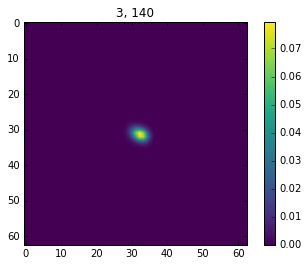

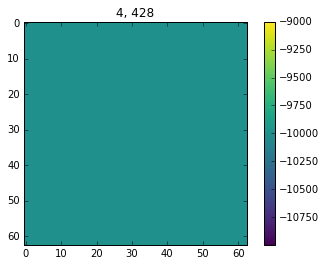

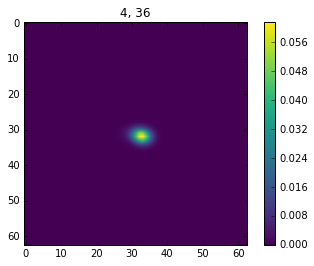

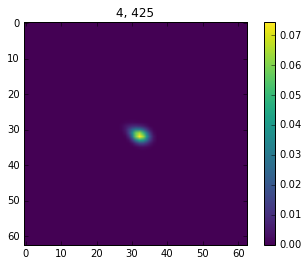

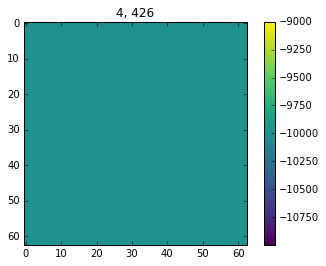

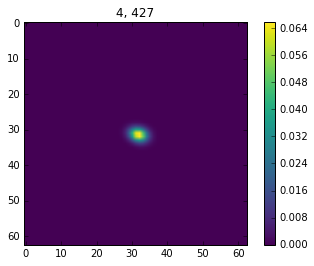

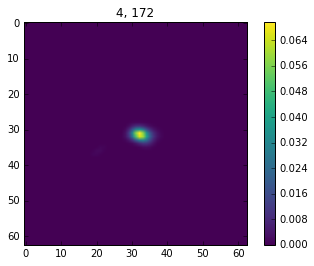

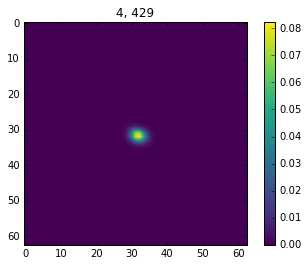

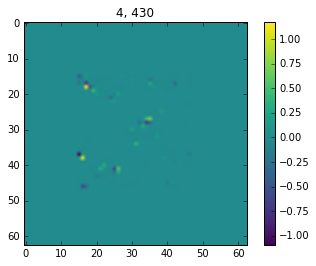

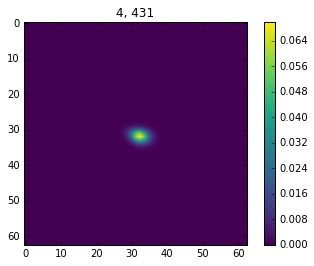

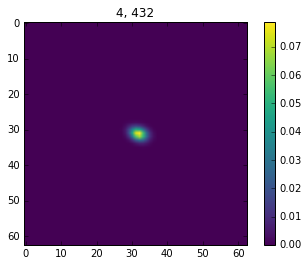

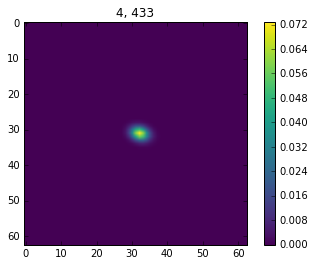

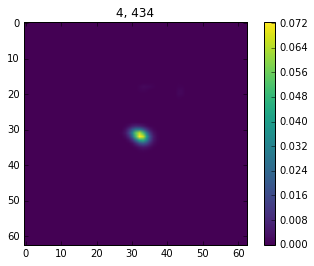

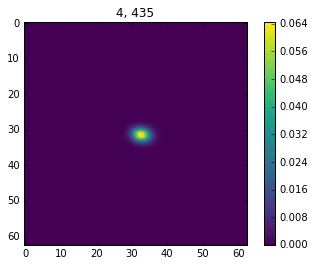

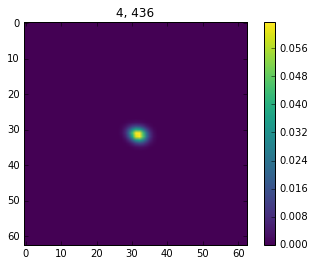

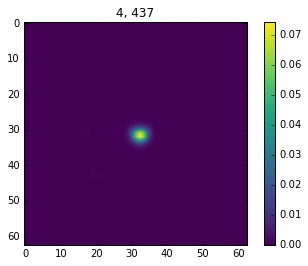

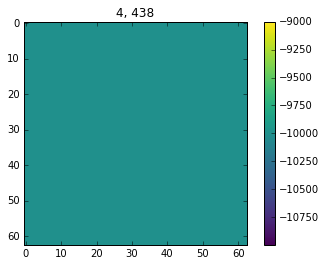

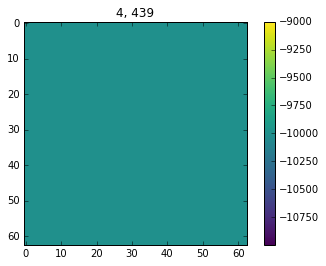

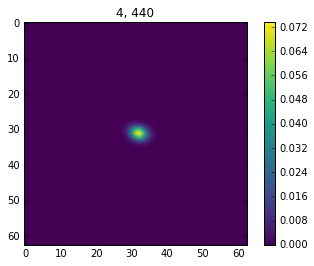

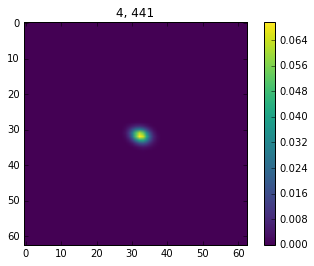

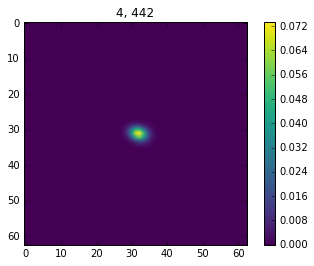

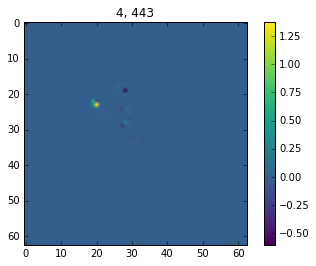

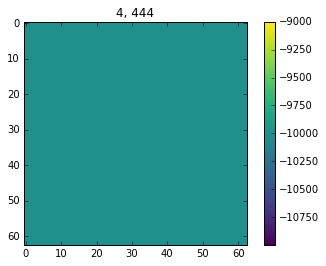

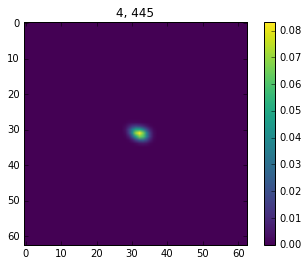

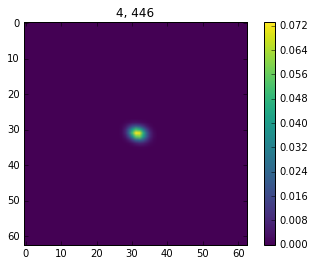

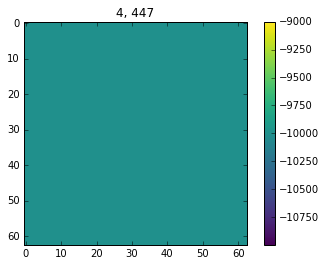

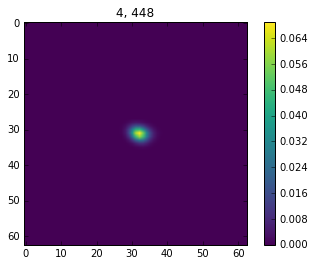

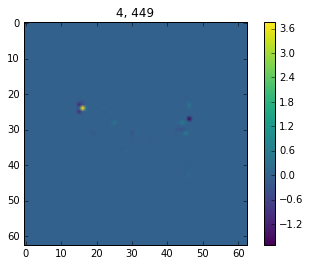

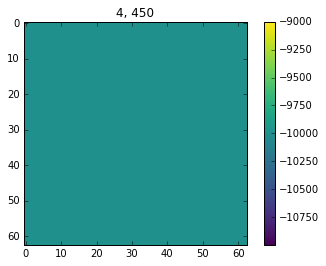

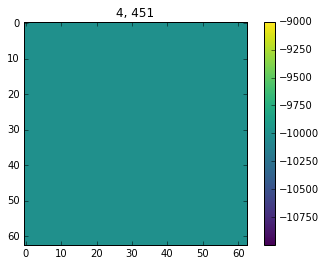

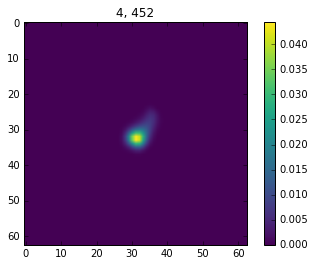

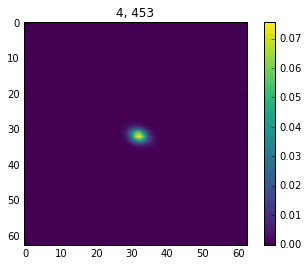

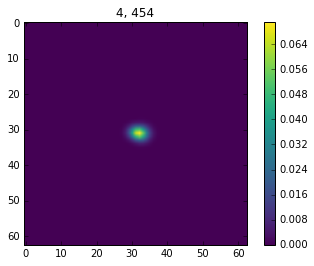

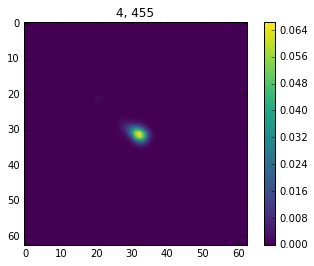

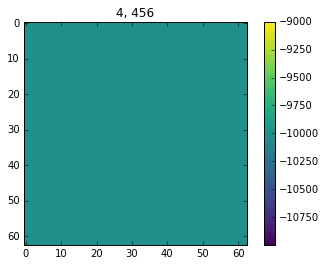

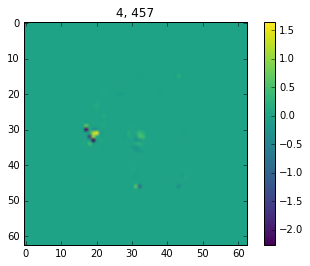

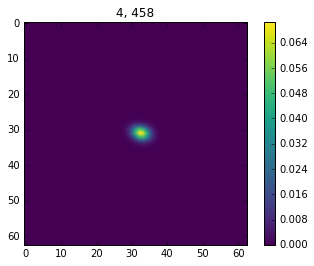

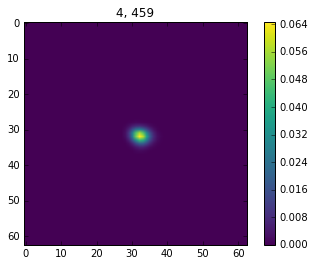

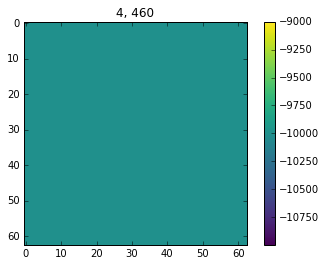

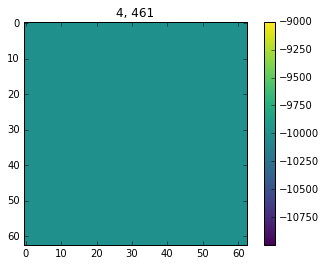

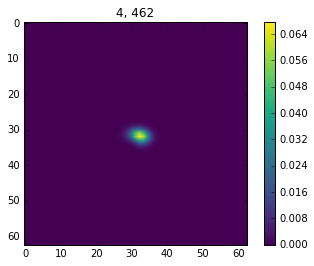

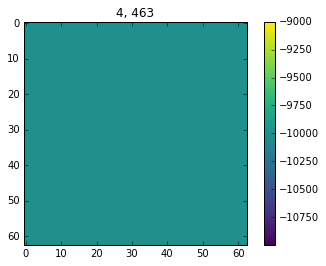

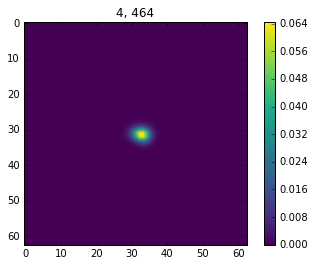

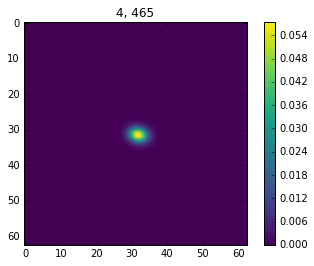

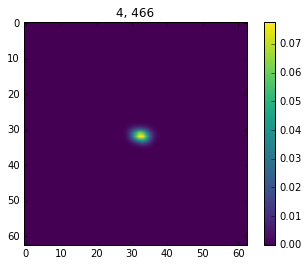

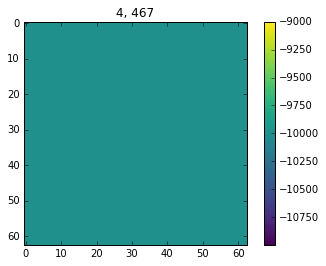

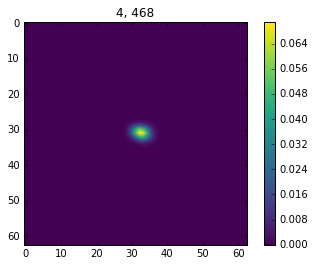

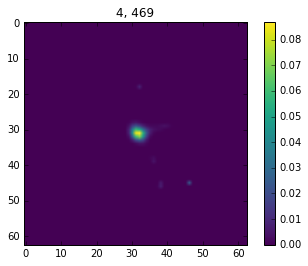

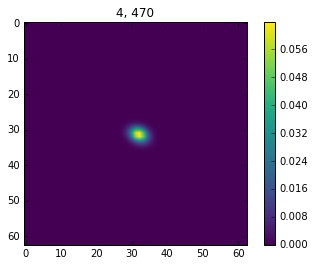

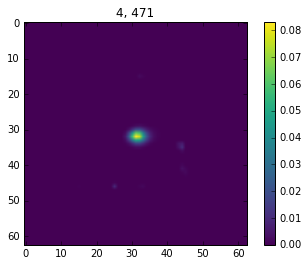

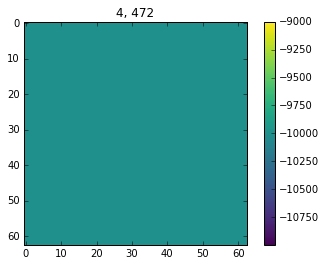

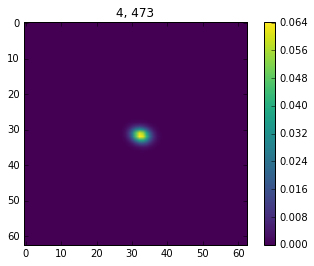

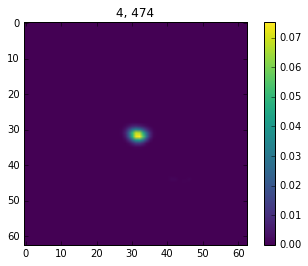

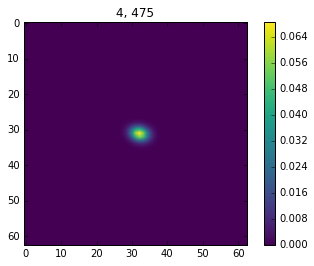

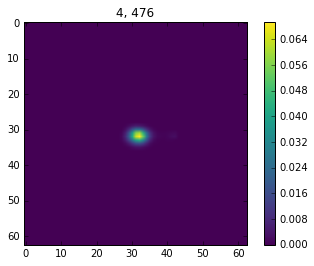

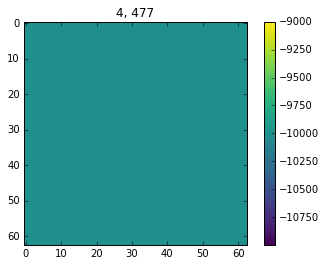

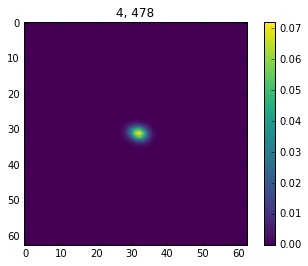

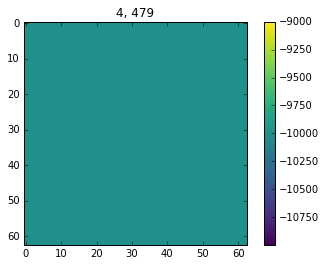

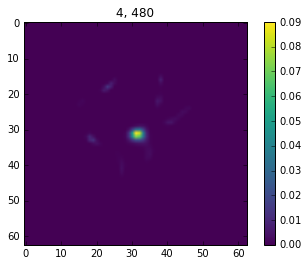

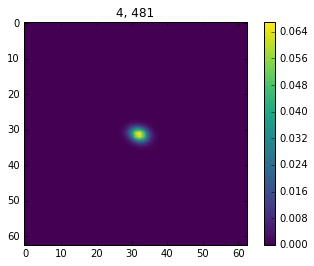

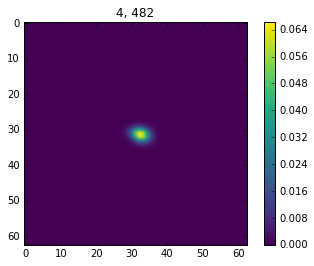

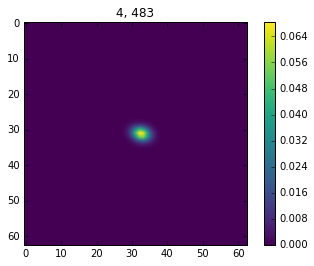

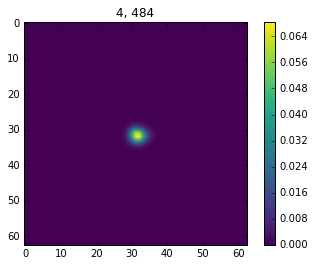

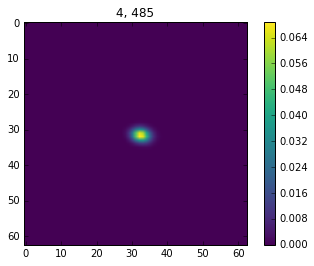

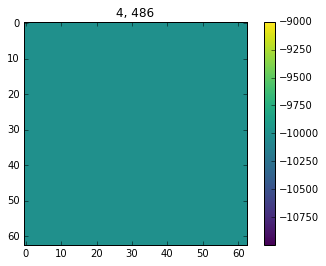

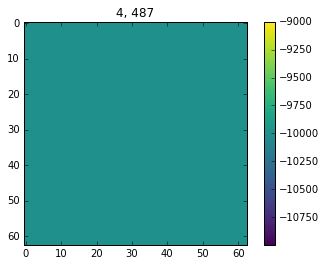

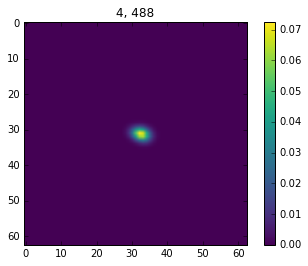

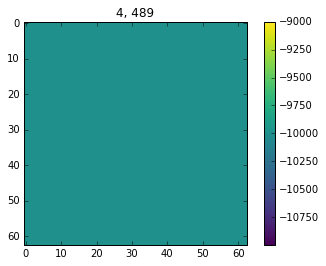

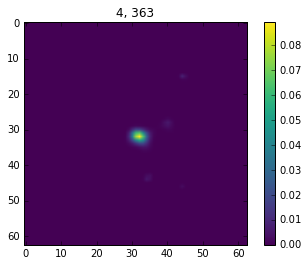

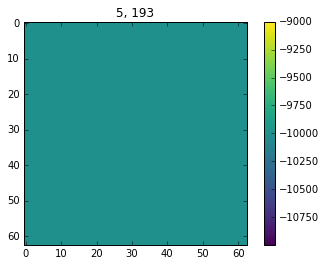

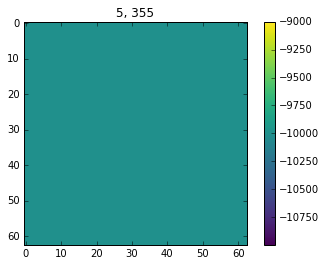

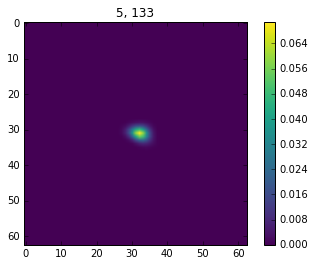

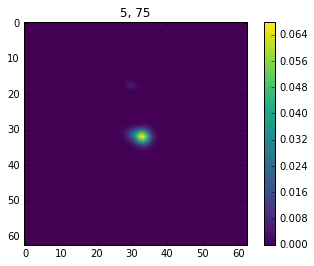

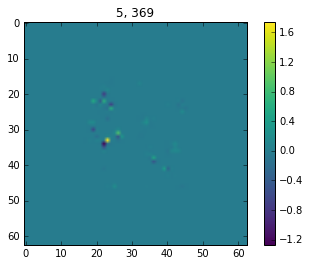

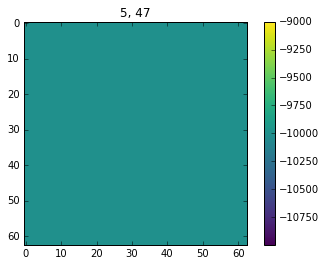

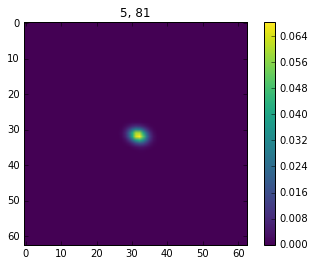

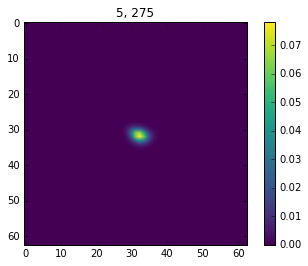

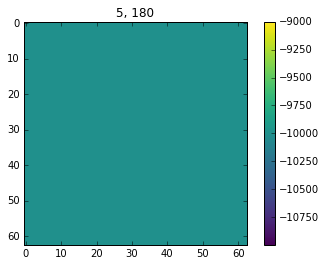

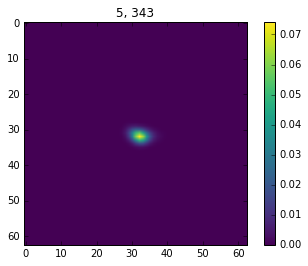

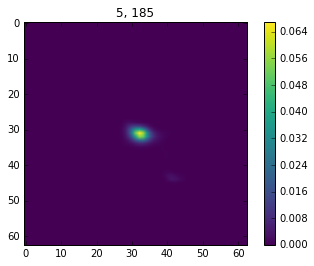

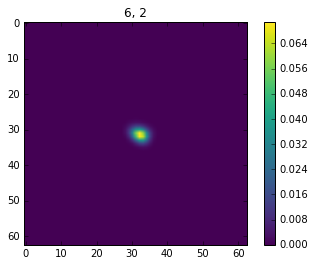

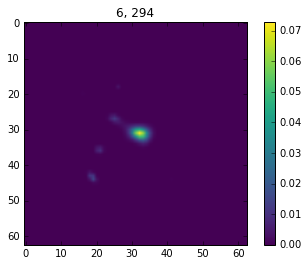

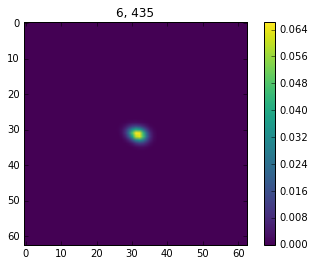

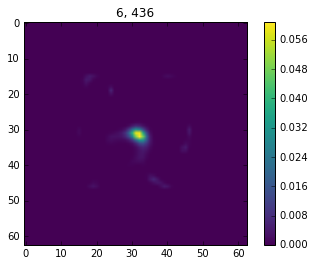

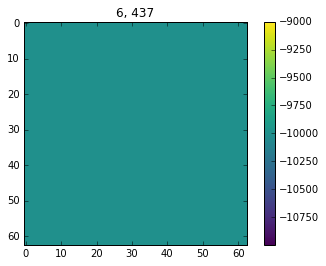

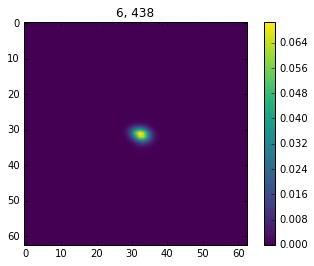

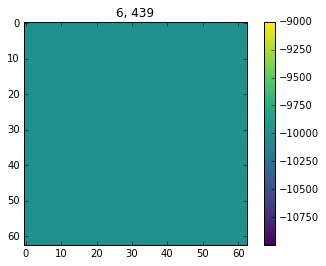

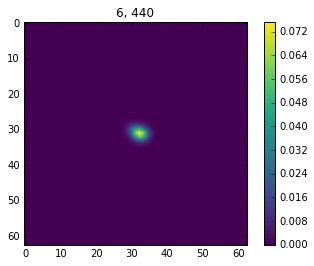

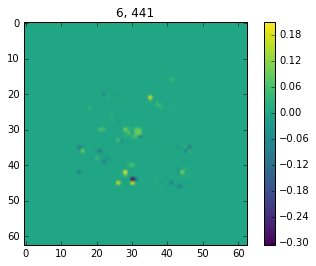

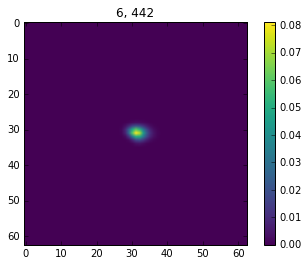

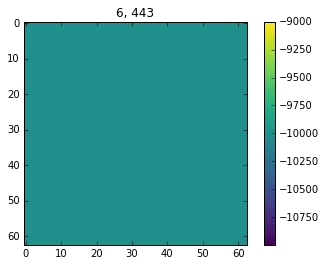

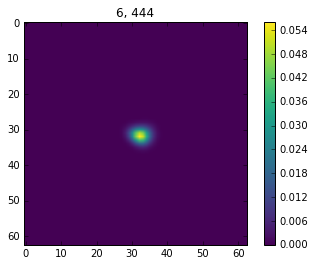

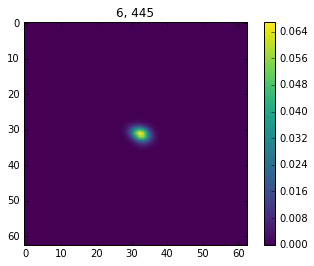

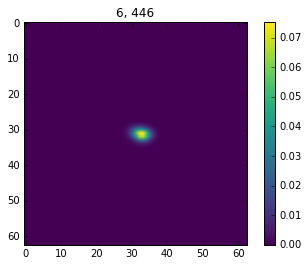

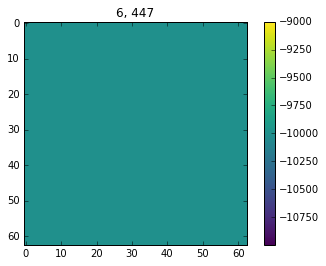

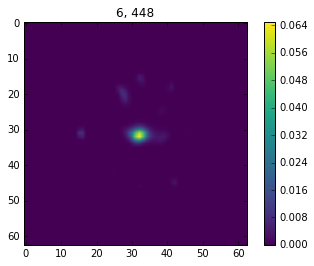

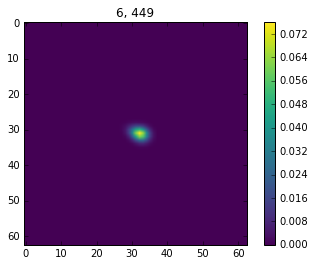

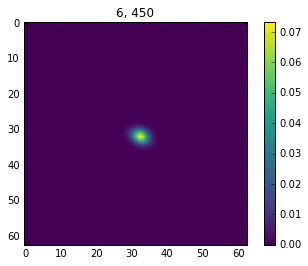

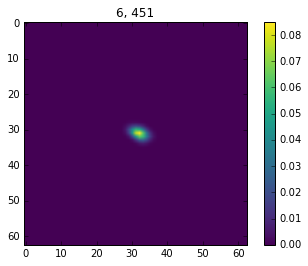

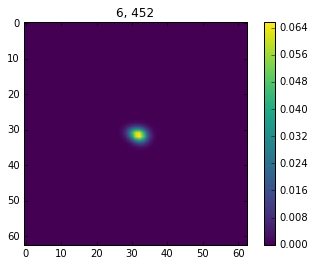

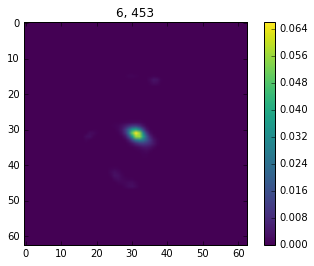

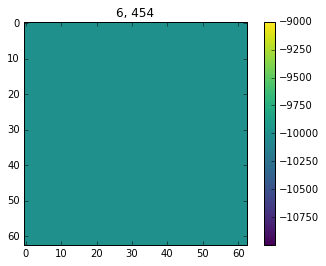

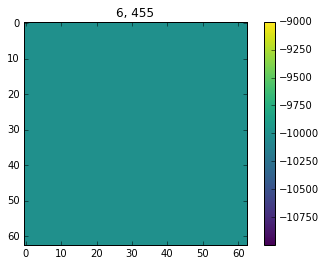

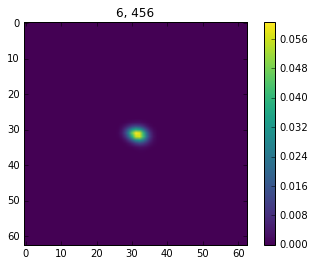

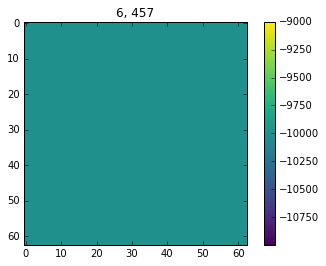

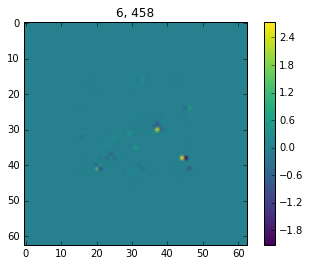

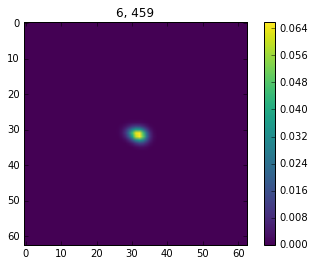

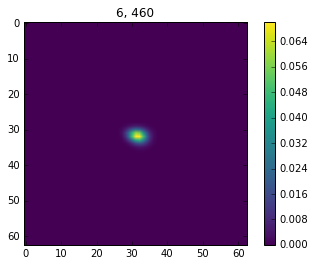

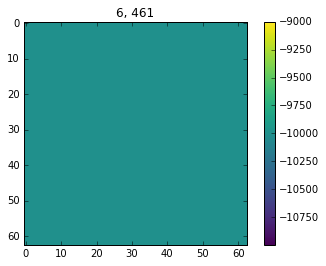

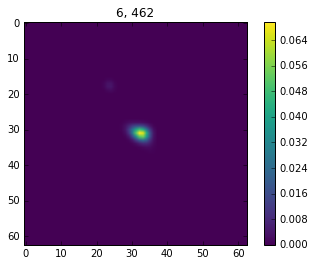

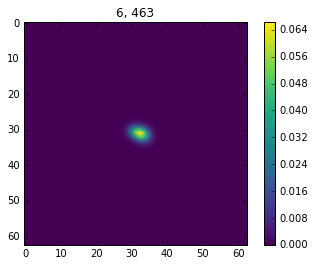

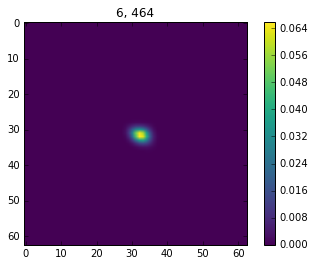

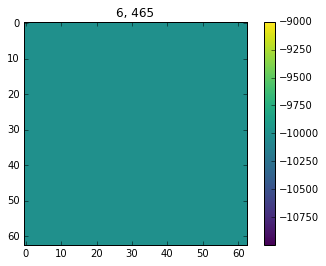

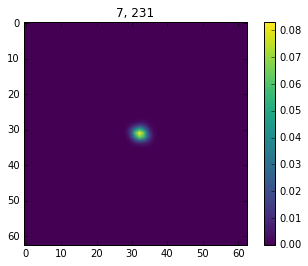

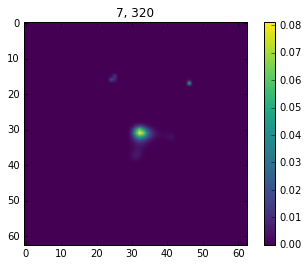

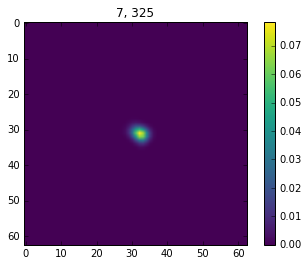

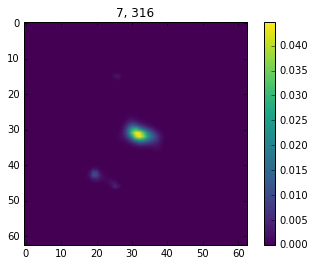

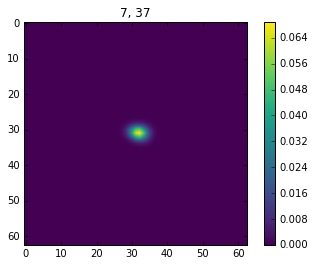

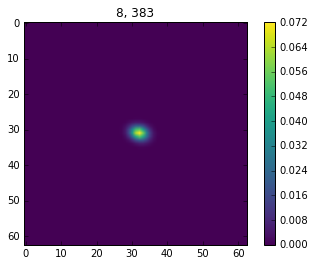

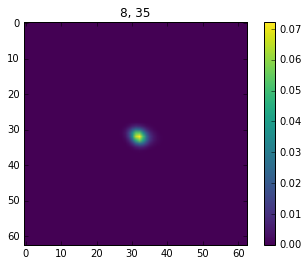

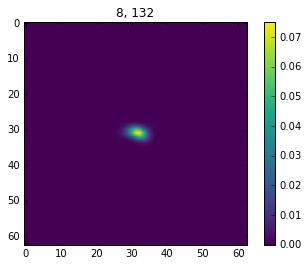

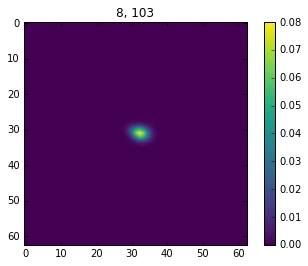

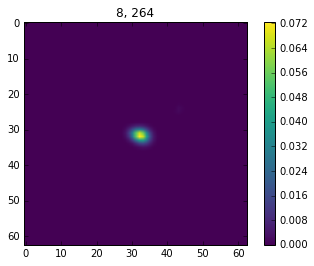

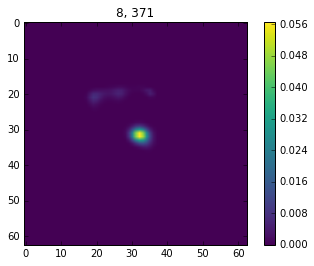

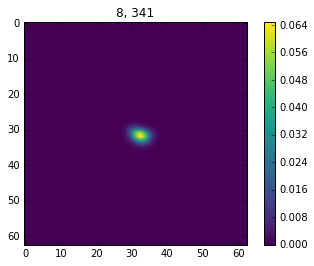

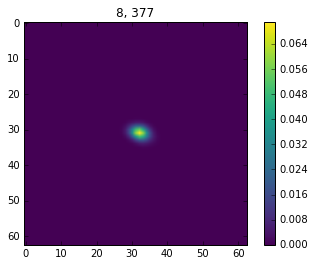

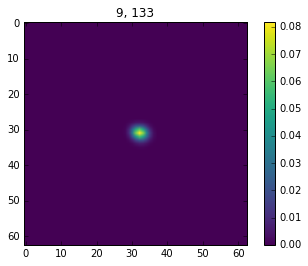

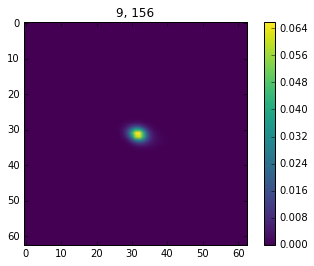

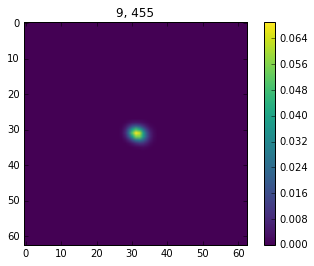

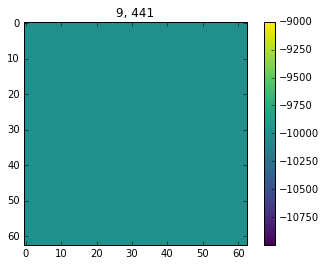

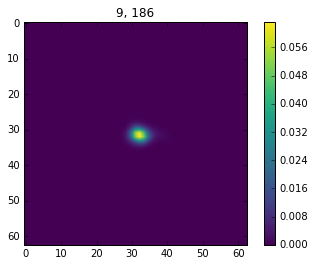

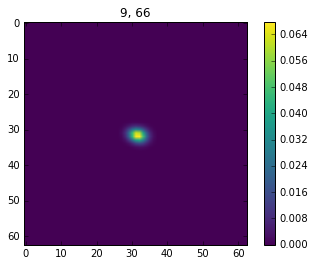

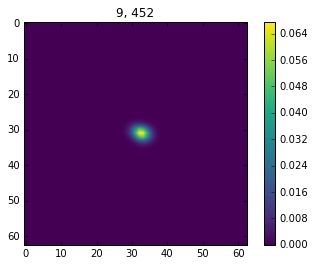

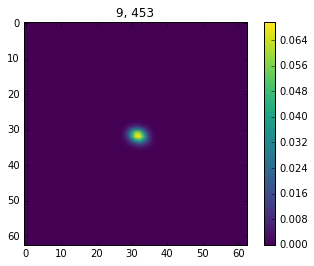

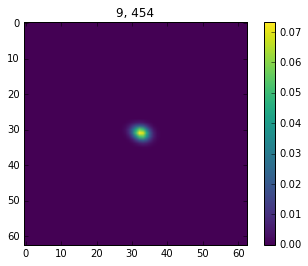

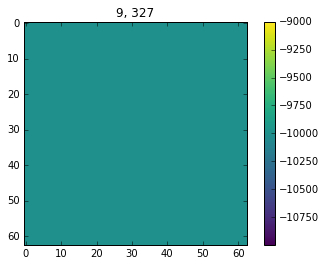

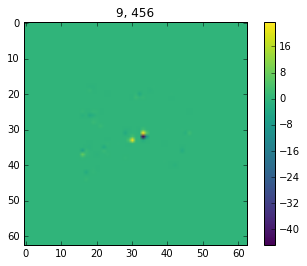

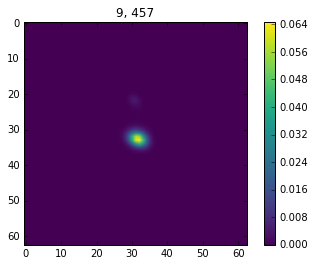

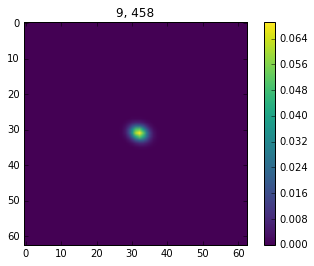

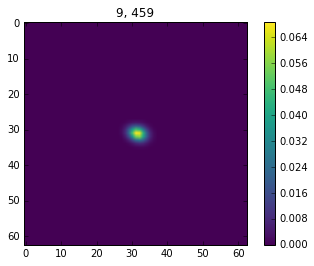

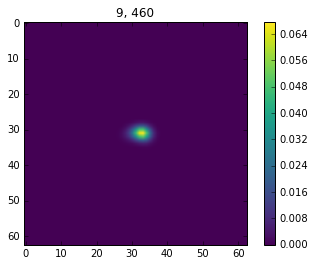

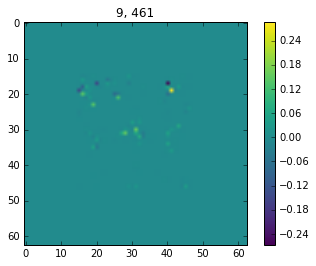

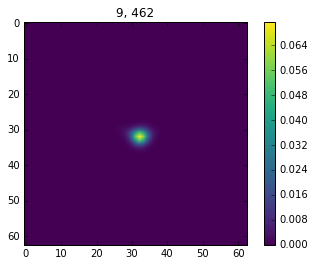

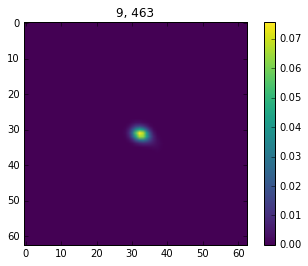

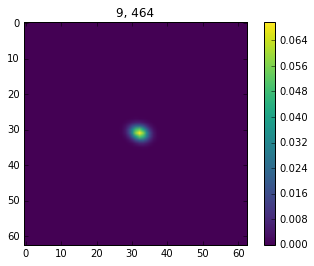

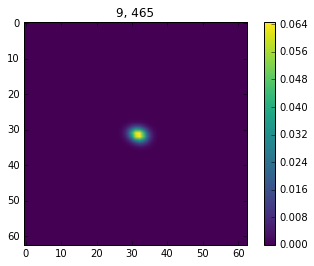

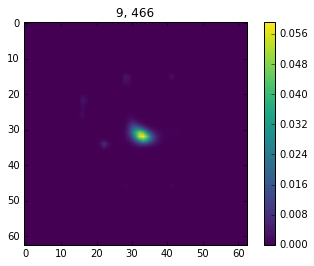

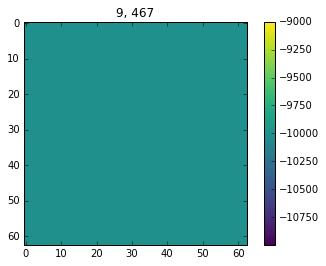

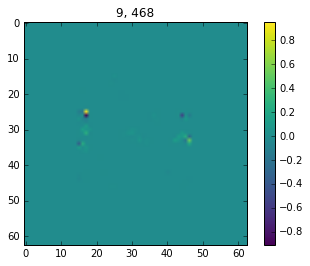

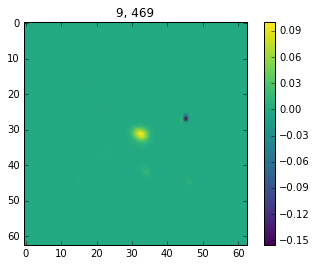

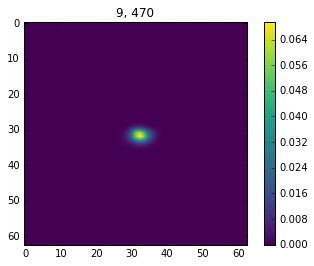

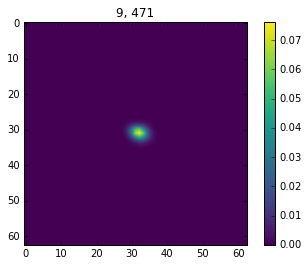

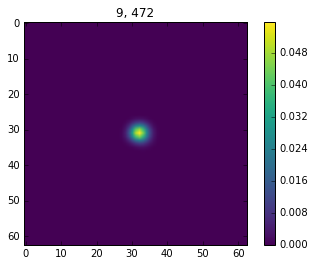

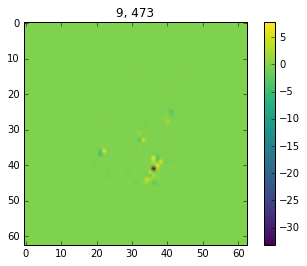

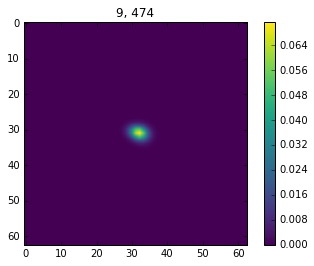

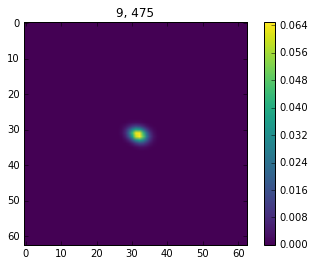

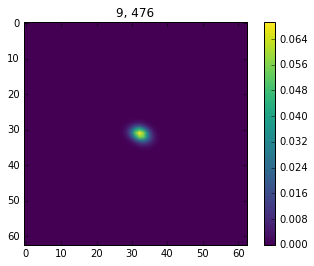

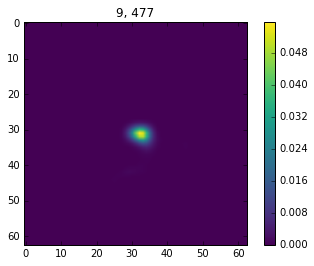

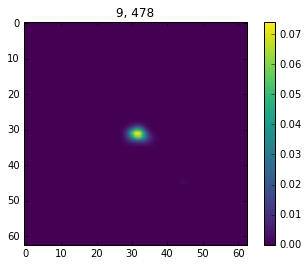

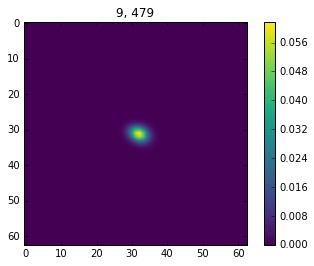

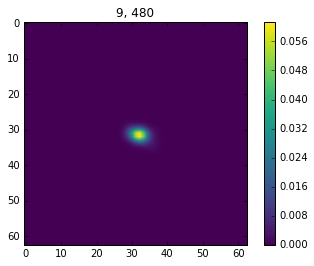

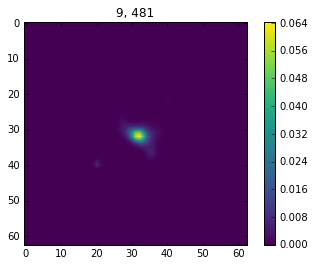

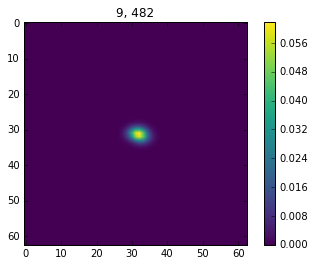

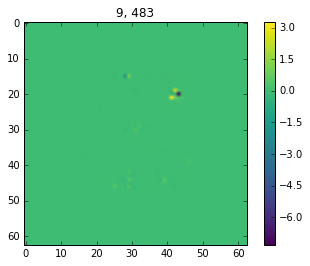

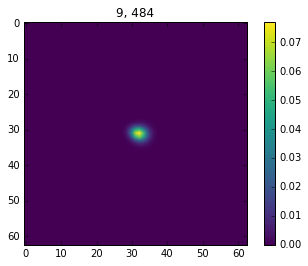

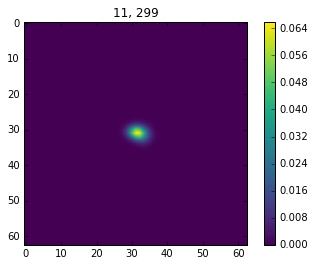

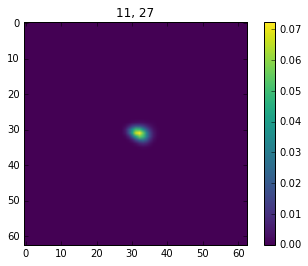

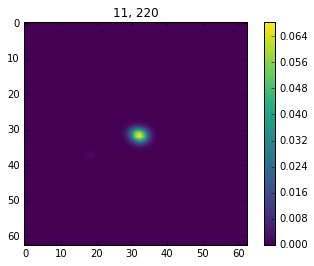

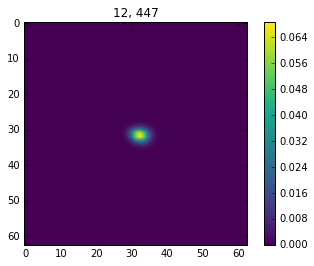

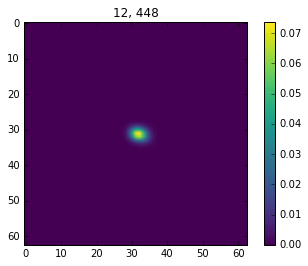

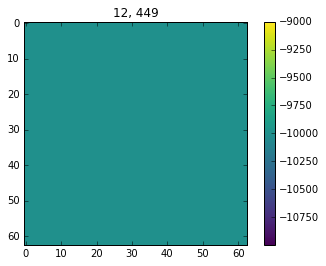

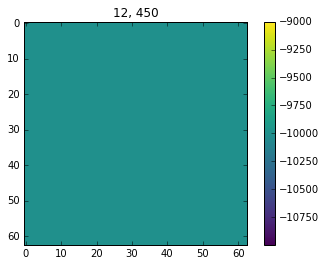

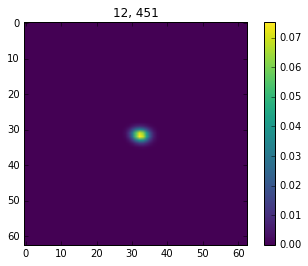

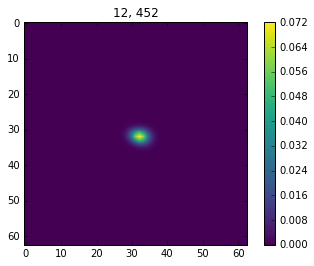

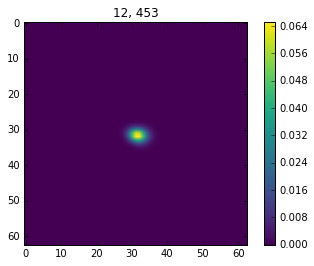

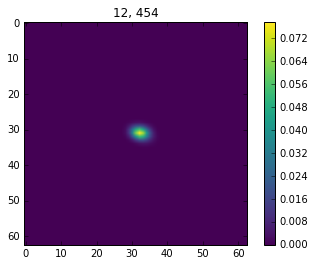

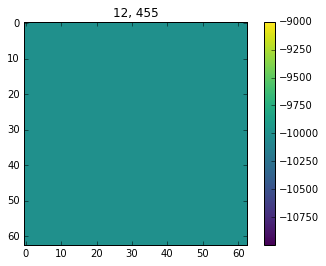

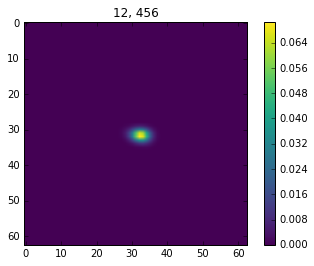

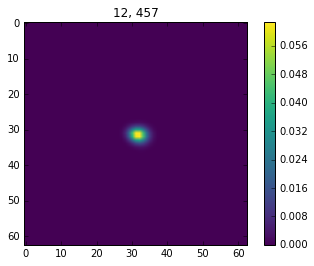

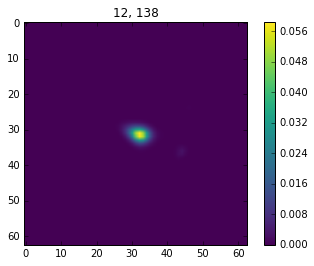

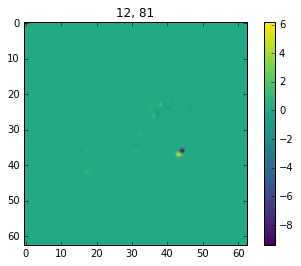

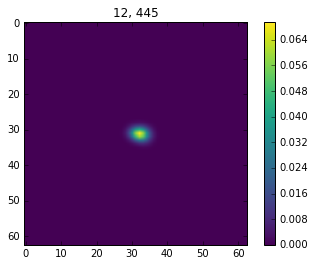

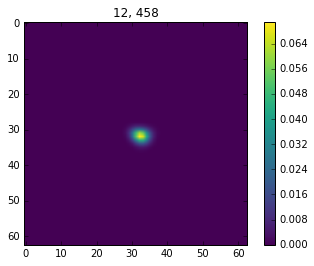

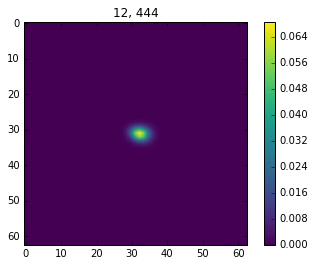

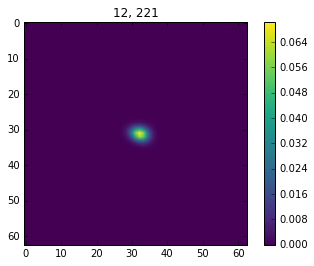

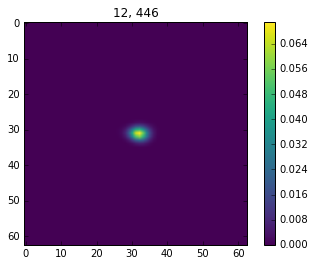

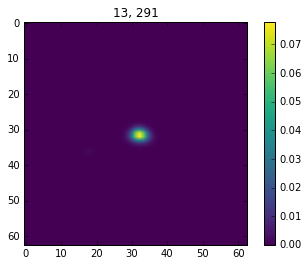

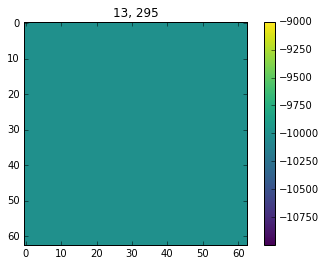

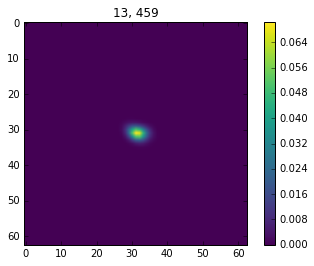

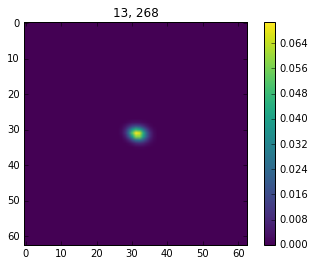

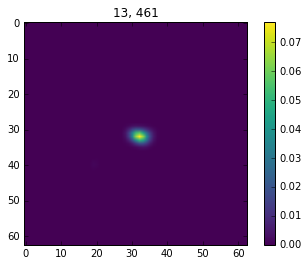

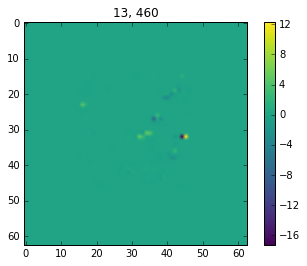

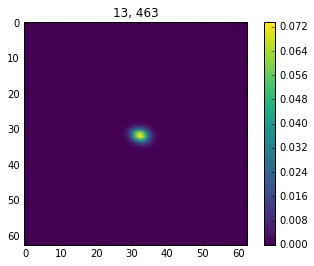

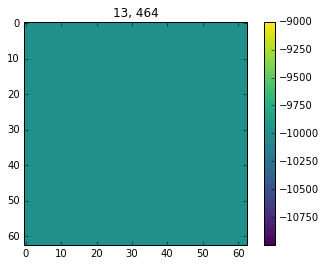

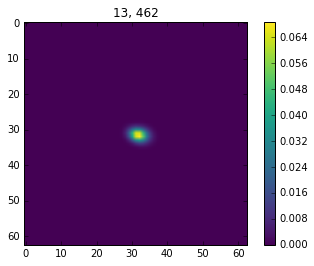

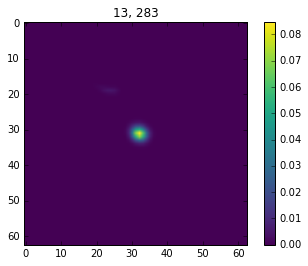

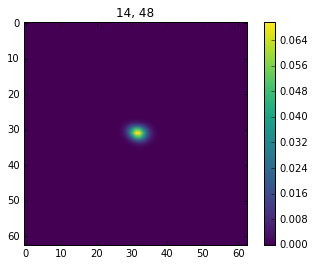

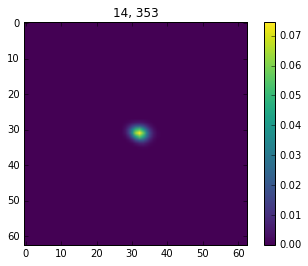

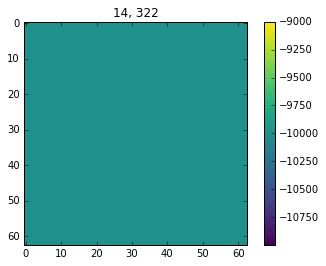

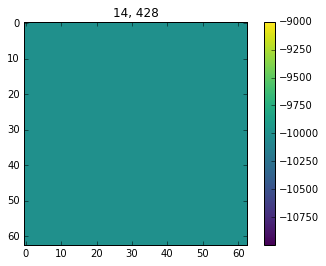

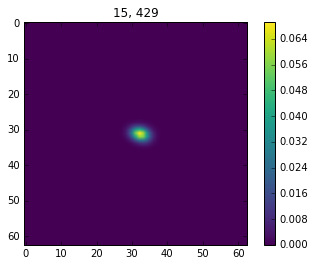

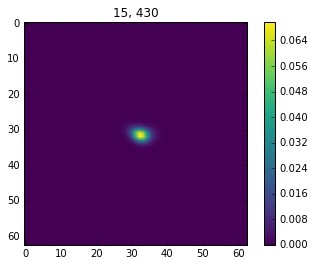

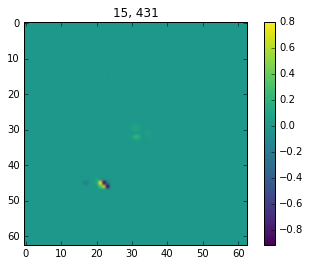

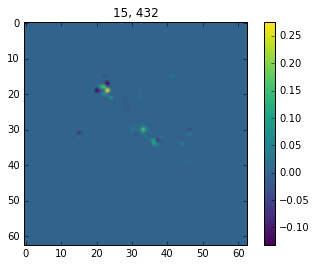

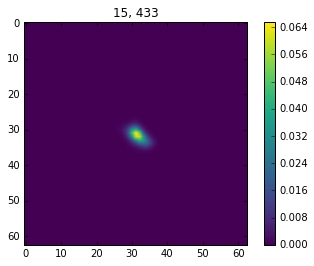

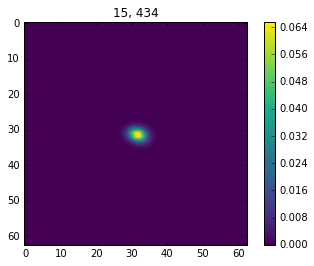

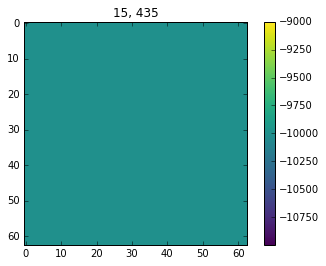

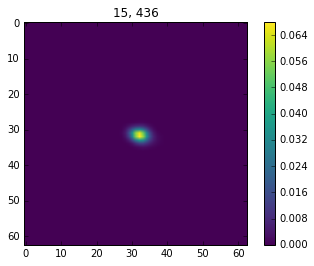

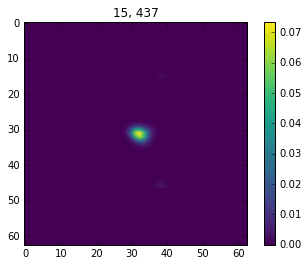

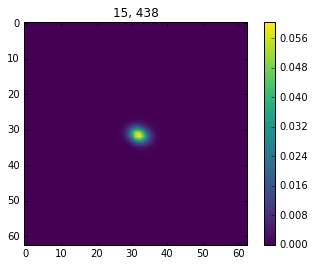

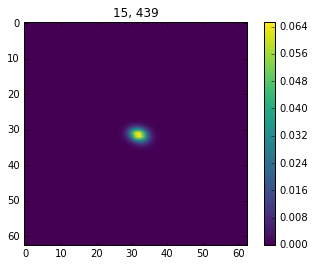

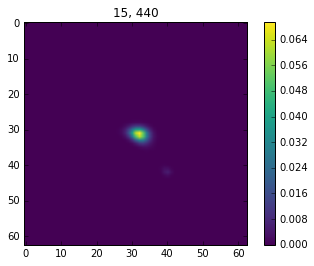

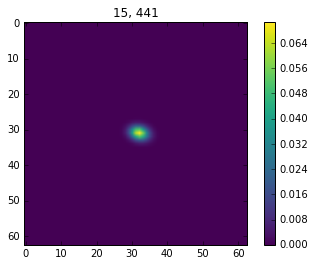

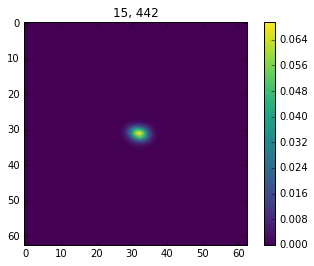

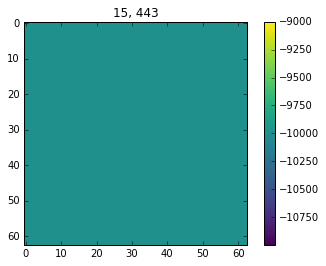

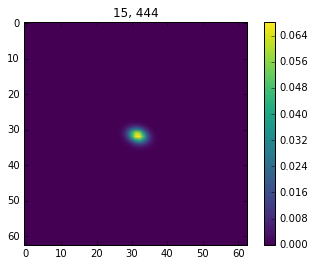

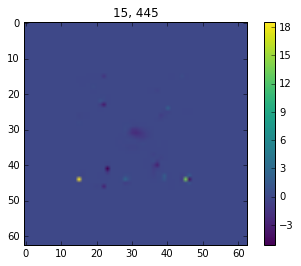

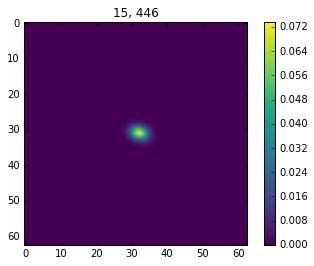

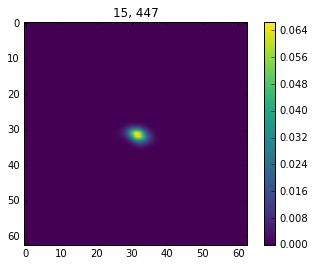

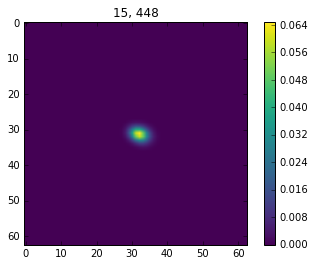

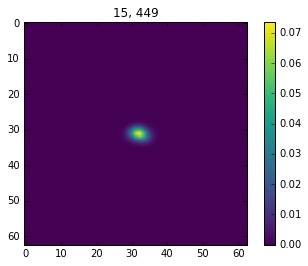

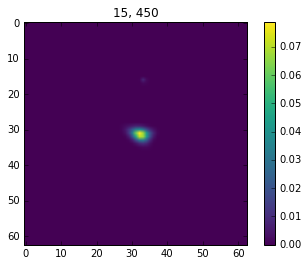

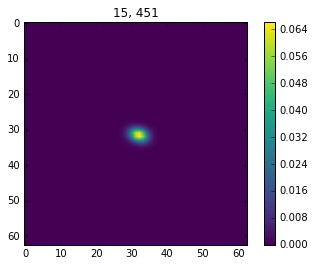

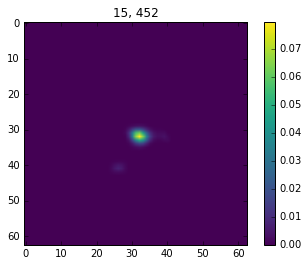

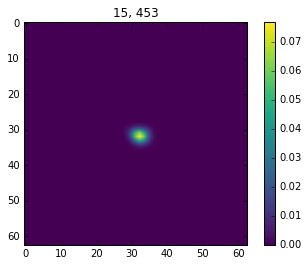

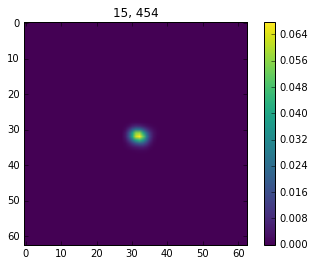

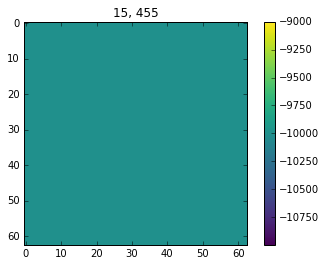

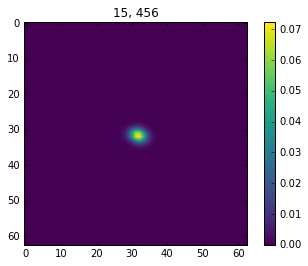

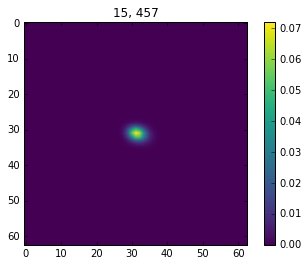

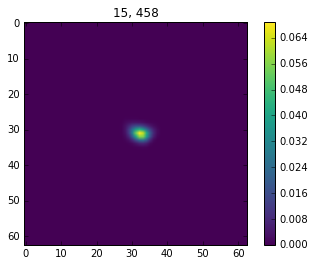

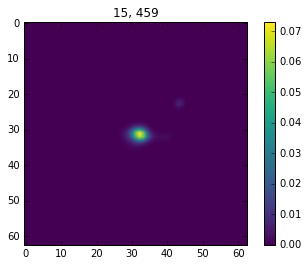

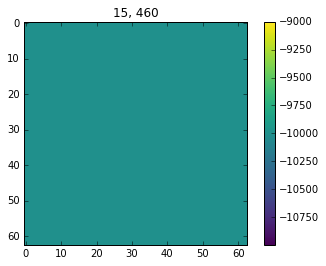

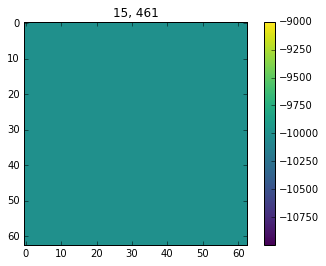

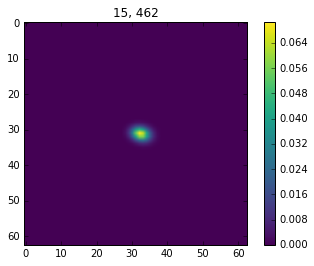

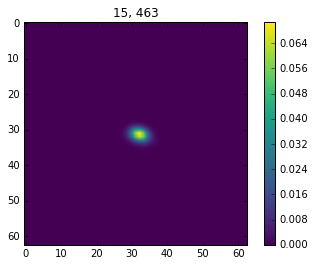

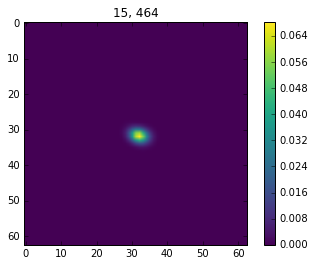

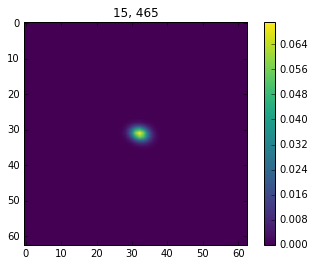

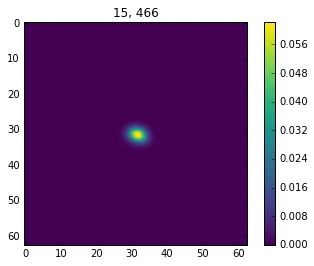

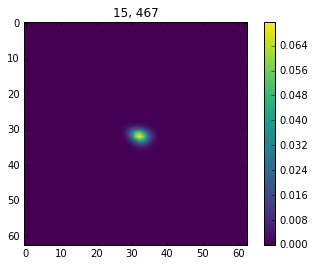

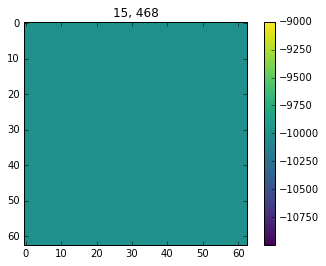

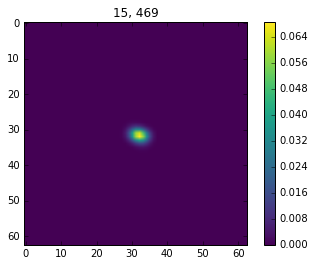

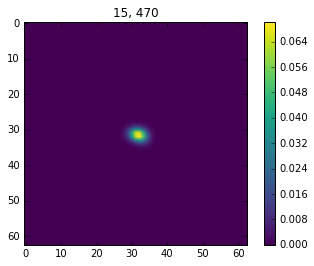

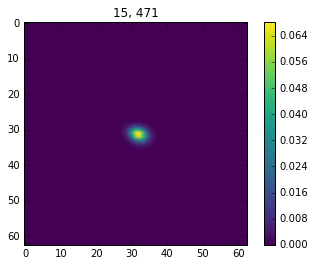

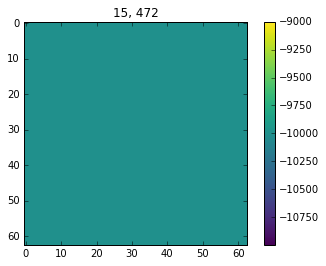

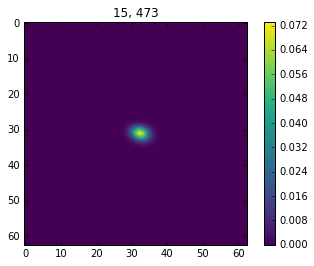

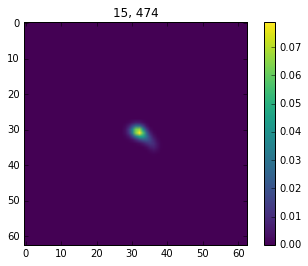

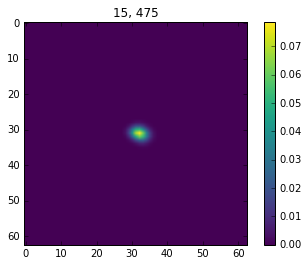

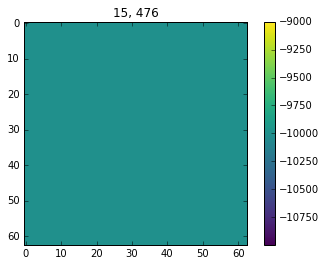

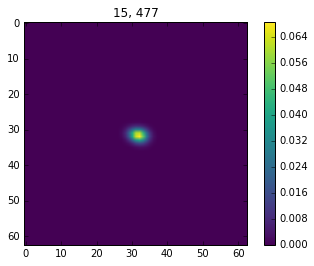

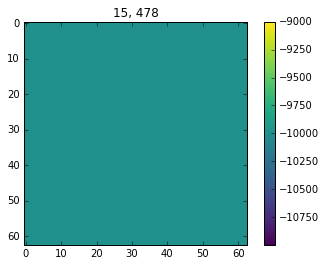

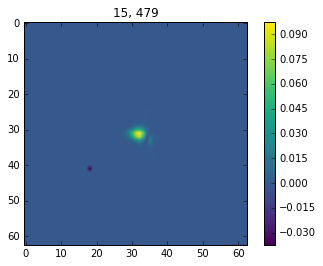

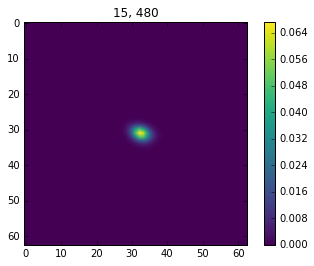

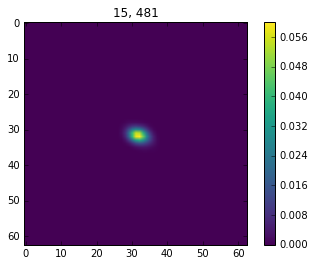

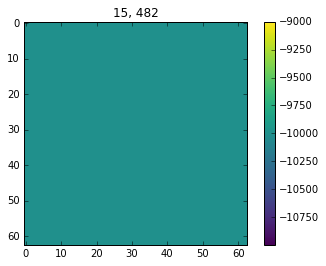

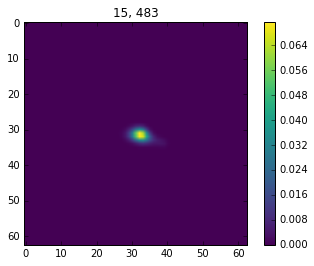

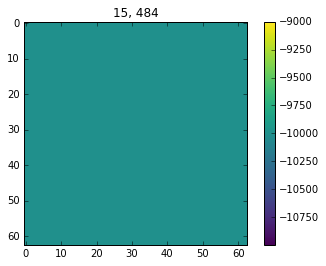

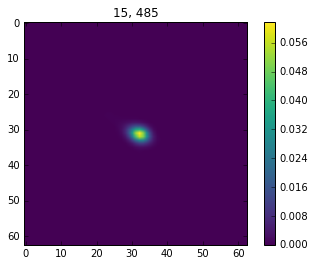

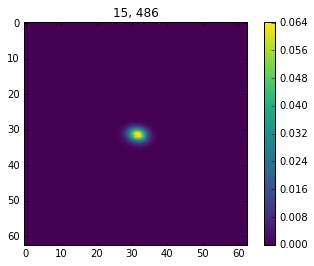

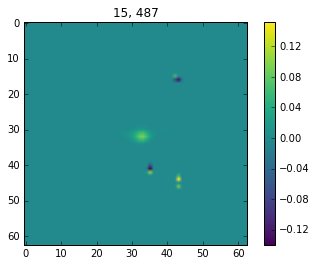

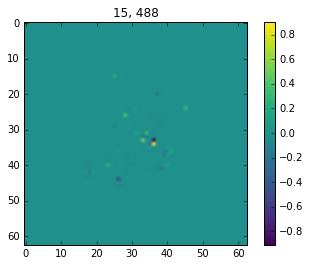

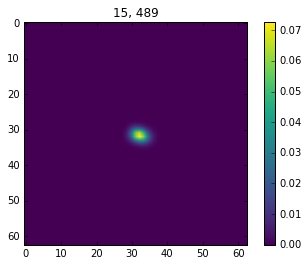

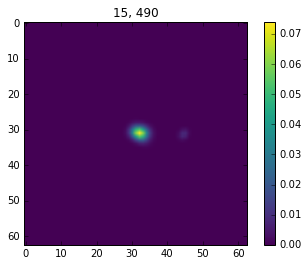

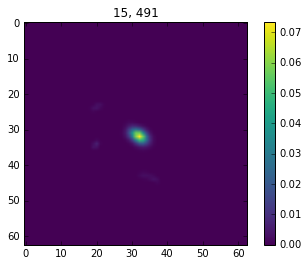

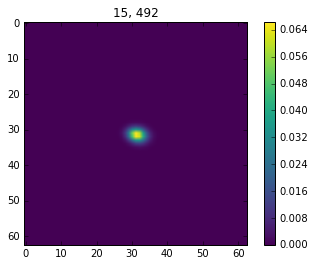

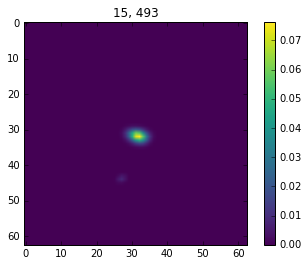

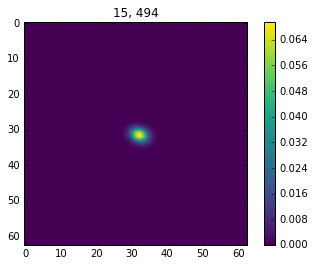

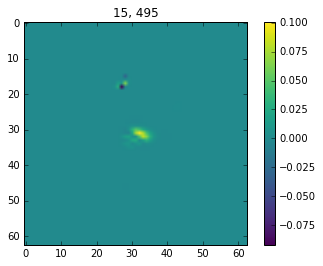

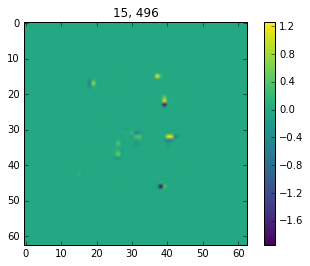

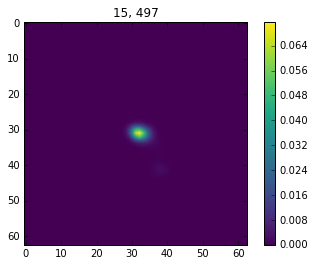

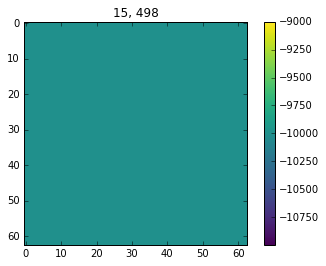

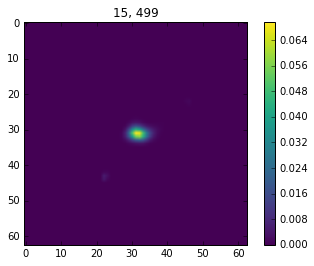

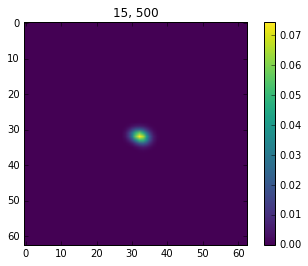

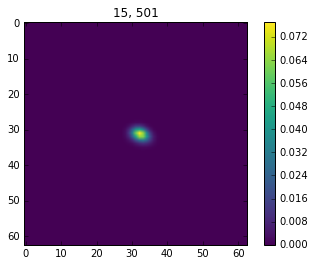

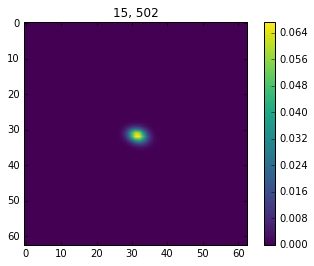

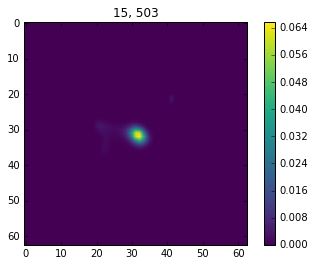

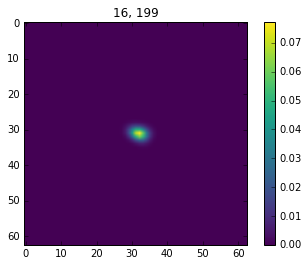

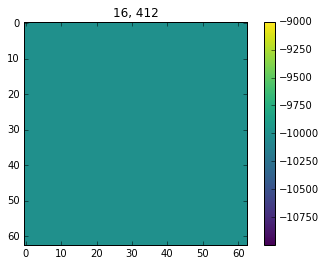

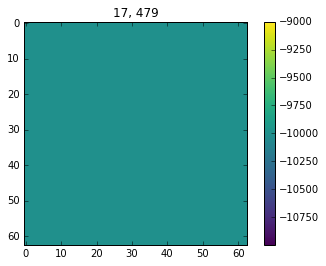

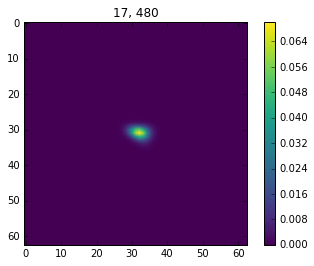

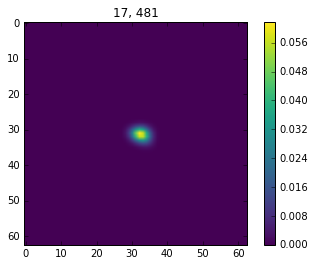

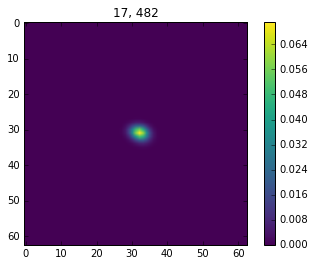

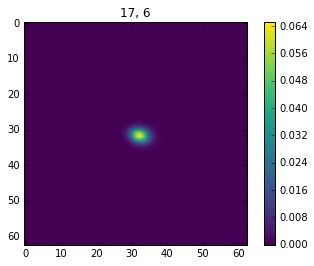

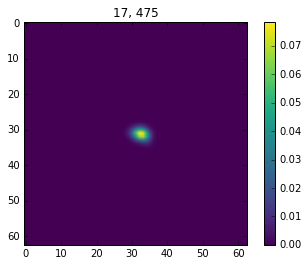

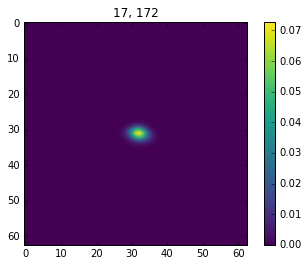

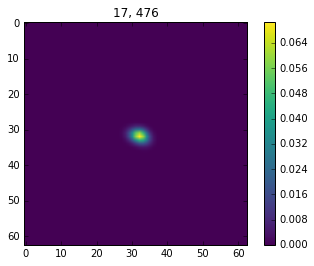

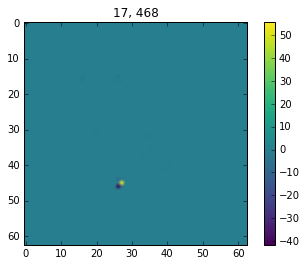

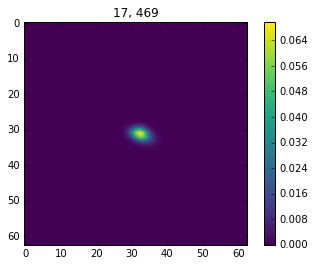

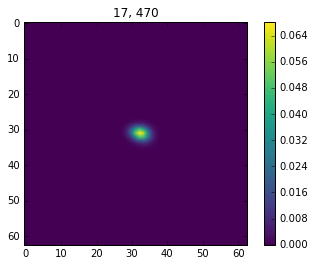

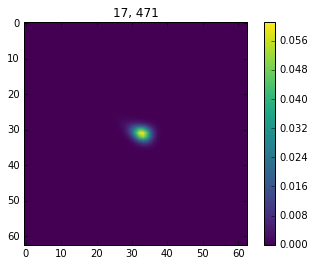

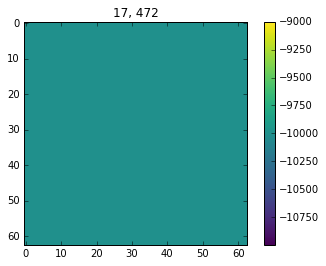

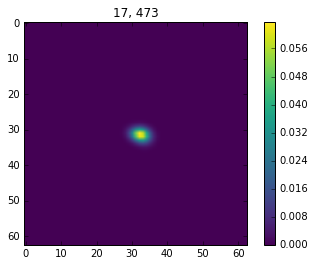

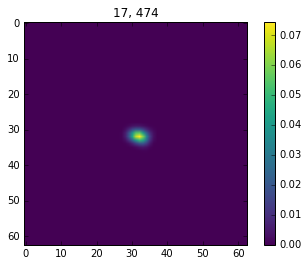

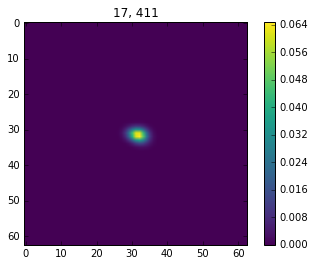

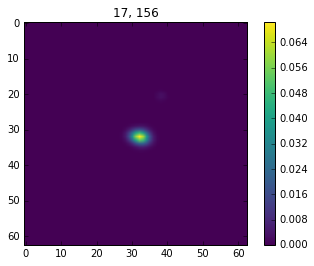

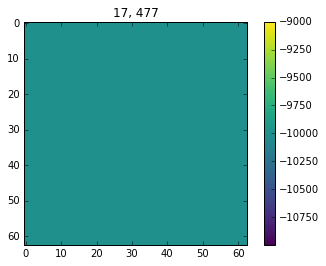

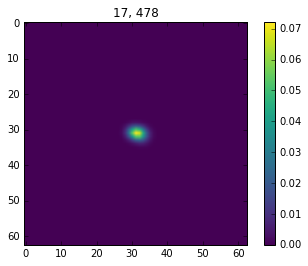

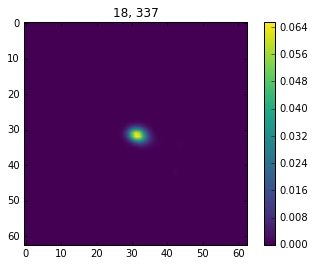

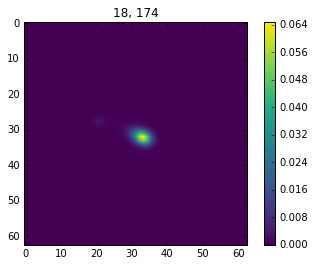

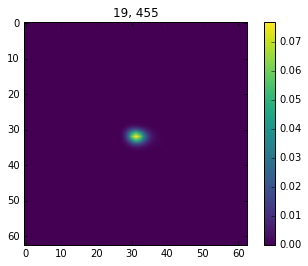

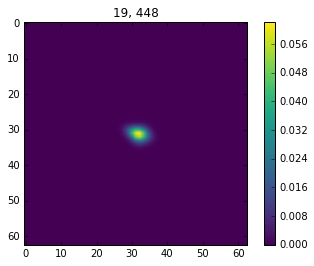

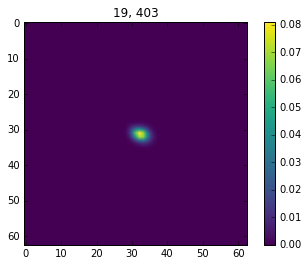

KeyboardInterrupt: 

In [9]:
for key, val in psfex_bad_stars.iteritems():
    hdu = meta_hdulist[key]
    for v in val:
        vig = hdu[2].data['VIGNET'][int(v-1)]
        plt.title('%s, %s'%(key, v-1))
        im = plt.imshow(vig)
        plt.colorbar(im)
        plt.show()

In [10]:
print len(psfex_bad_stars)

60


In [11]:
print starminusopt.shape[0] -len(used_stars)

NameError: name 'starminusopt' is not defined

In [12]:
out_base = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/'
deconvstarsminusopt_loc = out_base + '{0:08d}/{0}_stars_minus_opt.npy'.format(expid)
starminusopt = np.load(deconvstarsminusopt_loc)

MASK_VAL = -9999
good_stars = []
for idx, resid in enumerate(starminusopt):
    if not np.any(resid == MASK_VAL):
        good_stars.append(idx)
good_stars = np.array(good_stars)
print(starminusopt.shape[0]-good_stars.shape[0])

5420


In [13]:
#Amount of "good stars"
print (good_stars.shape[0])/float(starminusopt.shape[0])

0.811962253677
